# AI Text Cassification with PyTorch, LSTM and CNN

**Taavi Kalaluka, 2024**

## Introduction

The idea for this project came from a deep interest in AI, specifically recent advances in Natural Language Processing. Ever since the advent of ChatGPT, I've been wondering how it will impact our society. Recently, I've been wondering about its effect on education. How many students around the world are using it to do their work? It's not all bad, since Large Language Models can be incredibly helpful tools for learning (I use them myself on a daily basis). However, if it's a subject you're not interested in, it's easy to get lazy and rely on them to do all the work for you. How will academic integrity be ensured? How will the education system adapt to this incredible new technology?

Then I remembered reading about an AI detection tool on Instagram, where an American college student had created a system for identifying AI text. I was sceptical at how well such a tool would work. How could you possibly detect AI in text? Human text is so complex, and humans have very different writing styles. I hypothesized that he must have used AI to detect AI, fighting fire with fire. Perhaps he created a deep learning model capable of identifying patterns in AI-generated text which are not noticeable to humans. I always thought there was something odd about AI text, I often got the feeling when I was reading something that it was written by a language model but I've never been able to explain why I get that feeling, to actually justify my suspicions. I was motivated to build my own models to see how well they would work.

I've been tinkering with AI for quite a long time now, having completed Stanford Online's Machine Learning Specialization in early 2023 and messed around with custom versions of different LLMs in my free time. I initially thought that I would have to use a pre-trained language model for this project, and train a custom version to detect AI. However, I also figured that it would be an excellent learning experience to implement my own models from scratch, even though the results might not be as good.

I discovered [this dataset](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text/data) of AI and human generated text on Kaggle and it looked promising. I also decided to use PyTorch for the project since we used Tensorflow in this course and I thought it would be a good opportunity to use another deep learning framework. At first it was quite challenging, as PyTorch requires you to do many things manually which Tensorflow does automatically out of the box (thanks to Keras for making it so easy). Eventually I got the hang of it; implementing models with PyTorch requires writing a lot more code but, it has the advantage of allowing for more flexbility and customization. Overall, I learned a lot during this project and I'm excited by the opportunity to share my findings.

## Initial Processing

### Imports

In [1]:
# Libraries for basic operations
import pandas as pd
import numpy as np
from collections import Counter
import string

# Tqdm for
from tqdm import tqdm

# Seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch for model building
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# BERT Tokenizer for tokenizing
from transformers import BertTokenizer

# Scikit-learn for model evaluation
from sklearn.metrics import classification_report, confusion_matrix

# String and NLTK for initial dataset analysis
from nltk import ngrams
import string

# Colab library for loading dataset from Google Drive
from google.colab import drive

### Data loading and initial analysis

Google Colab was used for building this project, as the GPUs they have are better than any others I have access to. This made training significantly faster, and allowed me to test many different versions of the model without frying my computer. The cell below shows the GPU this notebook was run with:

In [2]:
!nvidia-smi

Tue Mar  5 15:57:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

The data is on my Google Drive, so it's being mounted below. The original dataset was downloaded from Kaggle, and can be accessed [here](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text/data).

In [3]:
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/AI classification/data/AI_Human.csv')
df.head()

Mounted at /content/drive


,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


The dataset contains 487,235 rows, where each row is an example. The column `text` contains the essay and the column `generated` indicates whether it is human-written or AI-generated text:

- `0.0` = human
- `1.0` = AI

The `.csv` file is 1.11 GB in size, which is quite large for a file containing text. This is why I decided to use a smaller subset of the data for this project, containing only 10,000 examples. Using the whole dataset would take a very long time, especially since it involves not only training and testing, but tokenizing as well.

In [4]:
# Generating new dataframes for positive and negative classes
df_zero = df[df['generated'] == 0]
df_one = df[df['generated'] == 1]

# Sampling 5000 rows from each class
df_zero_sampled = df_zero.sample(5000, random_state=1)
df_one_sampled = df_one.sample(5000, random_state=1)

df = pd.concat([df_zero_sampled, df_one_sampled])
df.reset_index(inplace=True)
print(f'Number of rows in data subset: {len(df)}')

Number of rows in data subset: 10000


Here's what one of the essays looks like. They include all punctuation, and newline characters as well. I'll leave those in for this project, as they might contain valuable information:

In [37]:
df.iloc[0]['text']

"Many people have come to believe that the face on Mars was made by aliens. That, however, is wrong. The face on Mars is actually just a mesa. People will say, ¨That´s what the government wants you to think.¨ Those people are obviously ignoring all the logic and facts that say the face is just a normal landform.\n\nFirst, the so called face is just an illusion. It says so in the article. ¨...formed by shadows giving the illusion of eyes, nose, and mouth, ¨ is what the article said. So the face is just a trick of the eye. Those sneaky scientists.\n\nNASA thought this illusion would bring Mars some attention. Which it did. That's my next point. NASA released this face picture, so it would give some attention to NASA and Mars. If this face was made by aliens, I don't think that the government would release that information. Just a thought.\n\nFinally, this land from is similar to those in the Western part of the US. That right there proves everything. Larth was all volcanos at one point. 

The BERT tokenizer provided by the Hugging Face Transformers library was chosen for this project, due to its many advantages:

- **WordPiece Tokenization**: BERT uses WordPiece tokenization. This method breaks words into subwords, which can help models handle unseen words or rare words. For example, the word "unhappiness" might be tokenized into "un", "##happy", and "##ness".

- **Handling of Out-of-Vocabulary Words**: Thanks to WordPiece tokenization, BERT can handle out-of-vocabulary words, breaking them down into subwords that it has seen during training.

- **Multilingual Support**: The BERT tokenizer has multilingual support, meaning it can handle text in many different languages. The text in this project is in English, but it would be interesting to try it on other languages as well.

- **Efficiency**: The BERT tokenizer is efficient and can quickly tokenize large amounts of text.

- **Easy to Use**: With the Transformers library, using the BERT tokenizer is very simple, it can be done by instatiating a `BertTokenizer` class with the name of the pre-trained model you want to use.

Let's take a look at the dataset, by tokenizing it with `bert-base-uncased` and displaying distribution of tokens:

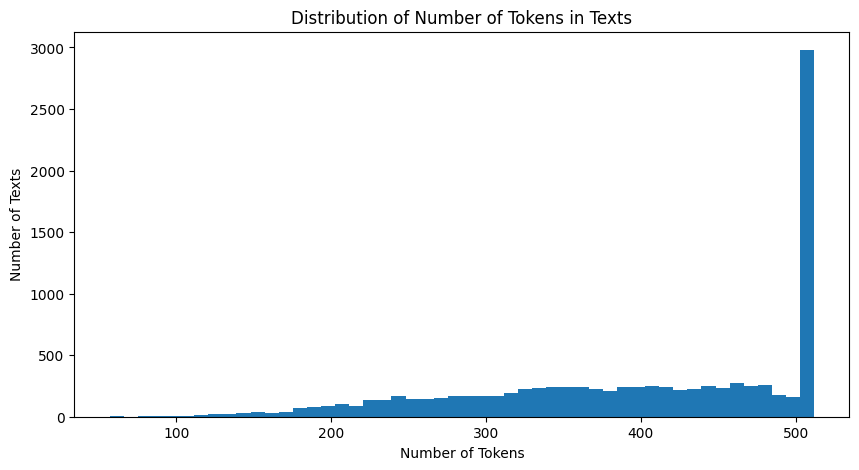

Maximum token length for the tokenizer: 512
Maximum number of tokens in a text: 512
95th percentile of number of tokens in a text: 512.0


In [31]:
# Initializing the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Extracting the maximum length of sequences that the tokenizer can handle
max_length = tokenizer.model_max_length

# Creating a copy of the dataframe for visualization purposes
df_visualization = df.copy()

# Tokenizing the text and calculating the number of tokens in each text
def tokenize_and_truncate(text, max_length):
    tokens = tokenizer.tokenize(text)
    return tokens[:max_length]

df_visualization['tokens'] = df_visualization['text'].apply(lambda x: tokenize_and_truncate(x, max_length))
df_visualization['num_tokens'] = df_visualization['tokens'].apply(len)

plt.figure(figsize=(10, 5))
plt.hist(df_visualization['num_tokens'], bins=50)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Texts')
plt.title('Distribution of Number of Tokens in Texts')
plt.show()

print(f'Maximum token length for the tokenizer: {max_length}')
print(f"Maximum number of tokens in a text: {df_visualization['num_tokens'].max()}")
print(f"95th percentile of number of tokens in a text: {df_visualization['num_tokens'].quantile(0.95)}")

From this histogram, it is evident that the vast majority of essays are around 512 tokens in length. The reason for such a massive spike around this value is most likely due to the maximum number of tokens allowed with the BERT tokenizer, which is 512. So, many of the essays were longer than 512 tokens, but they were truncated to 512 tokens. This will speed up the training and tokenizing process, but means that the models might be more accurate with a different tokenizer and more tokens.

Let's plot the most common tokens for the two classes:

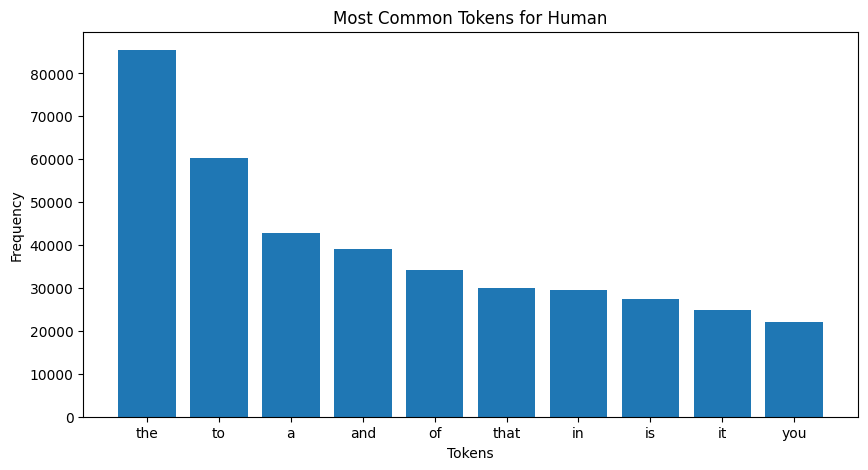

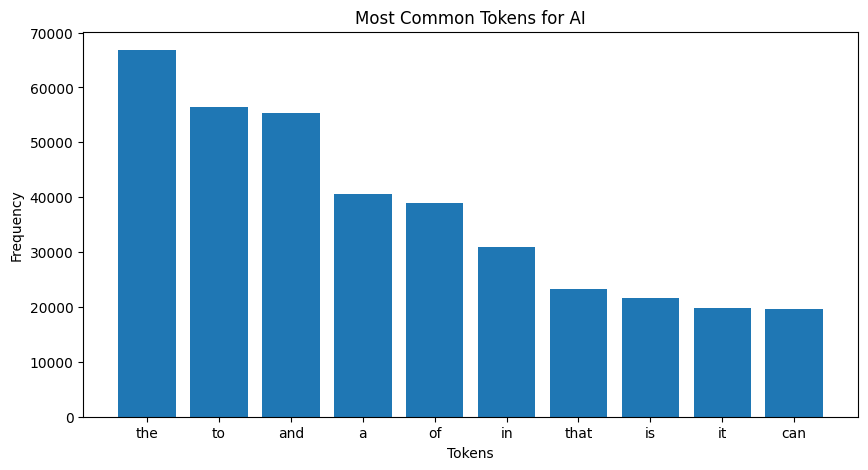

In [6]:
# Function to plot the most common tokens by class
def plot_common_tokens(df, class_value):
    df_class = df[df['generated'] == class_value]
    class_map = {0: 'Human', 1: 'AI'}

    # Filtering out tokens that are punctuation
    token_freq = Counter(token for tokens in df_class['tokens'] for token in tokens if token not in string.punctuation)

    common_tokens = token_freq.most_common(10)
    tokens, counts = zip(*common_tokens)

    plt.figure(figsize=(10, 5))
    plt.bar(tokens, counts)
    plt.title(f'Most Common Tokens for {class_map[class_value]}')
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.show()

# Plotting for AI and not AI
plot_common_tokens(df_visualization, 0)
plot_common_tokens(df_visualization, 1)

This visualization doesn't seem to be very useful, as most of the words are the same and their frequency is similar. Let's look at the top 3-grams (combinations of 3 words) for both classes:

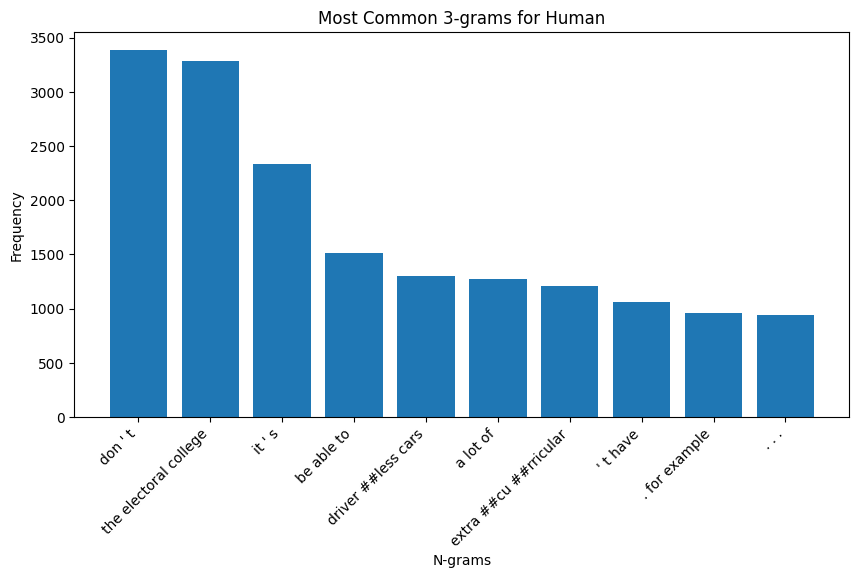

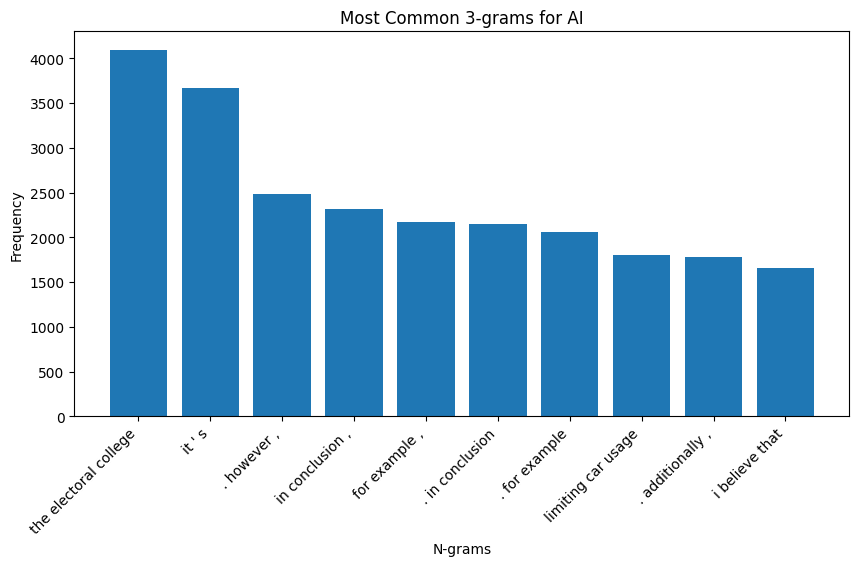

In [7]:
# Function to plot the most common n-grams by class
def plot_common_ngrams(df, class_value, n):
    df_class = df[df['generated'] == class_value]
    class_map = {0: 'Human', 1: 'AI'}

    # Generating n-grams - punctuation isn't being removed this time
    ngram_freq = Counter(ngram for tokens in df_class['tokens'] for ngram in ngrams(tokens, n))

    common_ngrams = ngram_freq.most_common(10)
    ngrams_ , counts = zip(*common_ngrams)

    plt.figure(figsize=(10, 5))
    plt.bar([' '.join(ngram) for ngram in ngrams_], counts, align='center')
    plt.title(f'Most Common {n}-grams for {class_map[class_value]}')
    plt.xlabel('N-grams')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plotting 3-grams for AI and not AI
plot_common_ngrams(df_visualization, 0, 3)
plot_common_ngrams(df_visualization, 1, 3)

These do provide a little more insight into how the texts differ, but it's certainly not enough, and it doesn't make sense to build a model on N-grams or tokens alone. This is due to a few reasons:

1. **Lack of Semantic Understanding**: N-grams and tokens are purely syntactic features. They do not capture the semantic meaning of the text. AI-generated text can often mimic the syntax of human text quite well, making it difficult to distinguish based on these features alone.

2. **Overfitting**: If the most common n-grams or tokens are used to build a classifier, it might be overfitting to the specific patterns in the training data. This can make the model perform poorly on new data, especially if language models evolve and start generating different patterns.

3. **Commonality of Tokens**: Both human and AI texts use a lot of common words (tokens), making it hard to distinguish between the two. The most frequent N-grams or tokens are not be discriminative enough for the task.

4. **AI Training on Human Text**: AI models for text generation are typically trained on large amount of human-written text. Therefore, they learn to generate text that closely mimics the patterns (including common n-grams and tokens) in human writing. This can make it challenging to distinguish AI-generated text from human-written text based on these features.

5. **Variable Text Generation**: AI models can generate a wide variety of text based on their training and the input prompts. This variability can make it difficult to identify consistent patterns that distinguish AI-generated text from human-written text.

This is where machine learning models, specifically deep learning ones, come in handy. The are able to capture complex patterns and relationships between the texts, many of which humans wouldn't be able to notice.

Tokenizers are still crucial in building deep learning networks. Words need to be encoded into numerical form, so that the model can understand them.

Here's an example of how the BERT tokenizer works:

In [8]:
original_sentence = "Hello, I'm Taavi. I love AI and I'd love to work at OpenAI or Google Deepmind!"
tokens = tokenizer.tokenize(original_sentence)
input_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Original sentence:\n{original_sentence}')
print(f'Tokens:\n{tokens}')
print(f'Input IDs:\n{input_ids}')

Original sentence:
Hello, I'm Taavi. I love AI and I'd love to work at OpenAI or Google Deepmind!
Tokens:
['hello', ',', 'i', "'", 'm', 'ta', '##avi', '.', 'i', 'love', 'ai', 'and', 'i', "'", 'd', 'love', 'to', 'work', 'at', 'open', '##ai', 'or', 'google', 'deep', '##mind', '!']
Input IDs:
[7592, 1010, 1045, 1005, 1049, 11937, 18891, 1012, 1045, 2293, 9932, 1998, 1045, 1005, 1040, 2293, 2000, 2147, 2012, 2330, 4886, 2030, 8224, 2784, 23356, 999]


As we can see, the tokenizer splits the sentence into tokens, and some words have been split into smaller parts, like Taavi into "ta" and "##avi", OpenAI into "open" and "##ai", and Deepmind into "deep" and "##mind".

This is due to the WordPiece tokenizer mentioned earlier, that splits words into smaller parts if the word is not in its vocabulary.

The resulting input ids are usually converted to tensors for use in models which is done in the next section, with the `TextDataset` class.

### Creating The Dataset

This Custom `TextDataset` class inherits from PyTorch's `Dataset` class. An instance of the object takes in the following parameters:

1. `dataframe` - The dataframe from which the dataset should be created
2. `tokenizer` - The tokenizer to be used
3. `max_len` - The maximum length of each data input

In [9]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.generated
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        # Encoding and truncating/padding to max_len
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True
        )
        ids = inputs['input_ids']

        # Calculating the length of the sequence before padding
        text_length = len([token for token in ids if token != self.tokenizer.pad_token_id])

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'text_lengths': torch.tensor(text_length, dtype=torch.long)
        }

`__getitem__` will be called with each index in the dataframe later on by the data loaders. It takes in an index, and uses that index to access the specified row in the dataframe. The `text` (essay) is then extracted, encoded to `ids` and truncated/padded to `max_len`. This ensures that each input to the model has the same length. The `text_length`, which is the length of the text without padding, is required by the LSTM model in the forward pass. Everything is converted to tensors before being returned.

The following dictionary is returned for each call:

- `ids` - The texts (essays) as a tensor
- `targets` - The targets (human or AI, 0 or 1) as a tensor
- `text_lengths` - The lengths of the essays in tokens, excluding padding

Here, the `max_length` of the BERT tokenizer (512) is being used for the `max_len` parameter to create the dataset:

In [10]:
# Creating the Dataset
dataset = TextDataset(df, tokenizer, max_length)

Below is a function to create the data loaders, so that train/test/validation splits can be easily modified later on. They default to 75% for training, 10% for validation and 15% for testing, which will be used to create the data loaders used in this project.

The function returns data loaders for each of these using the specified parameters, taking in a `TextDataset` object created earlier.

In [11]:
def create_data_loaders(dataset, train_prop=0.75, val_prop=0.1, test_prop=0.15, batch_size=128):
    train_len = int(train_prop * len(dataset))
    val_len = int(val_prop * len(dataset))
    test_len = int(test_prop * len(dataset))

    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [12]:
train_loader, val_loader, test_loader = create_data_loaders(dataset)

## Long Short-Term Memory (LSTM)

### Building The Model

This class `LSTMClassifier` inherit's from PyTorch's `nn.Module` class, and defines the LSTM model to be used in this project.

It has the following components:

1. **Embedding Layer (`self.embedding`)**: This layer transforms the input words (represented as numbers) into dense vectors of fixed size. The `vocab_size` parameter is the number of unique tokens in the vocabulary, and `embedding_dim` is the size of the embedding vectors.

2. **LSTM Layer (`self.lstm`)**: This is the main component of the model. It's a type of recurrent neural network (RNN) that can learn long-term dependencies between words in the text. The `input_size` is the size of the input to each LSTM cell (which is the size of the `embedding_dim`), and `dimension` is the size of the hidden state and cell state of the LSTM.

3. **Dropout Layer (`self.dropout`)**: This layer randomly sets a fraction `p` of the input units to 0 at each update during training time, which helps prevent overfitting. `p=0.5` here, which works quite well.

4. **Linear Layer (`self.fc`)**: This layer is a linear transformation (y = Ax + b) that is applied to the output of the LSTM layer. It reduces the dimension from `dimension` to 1. The output of this layer is then passed through a sigmoid function to output a probability.

In the `forward` method, the input text is passed through each of these layers in turn. The LSTM layer uses packed sequences for efficiency (`pack_padded_sequence`), and the output from the LSTM is unpacked and the final hidden state is extracted and passed through the dropout and linear layers. The output is then squeezed to remove any extra dimensions and a sigmoid function is applied to get the final output probability.

In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dimension):
        super(LSTMClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dimension = dimension

        # LSTM layer of size dimension, with one layer
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Fully connected layer for outputting the final result
        self.fc = nn.Linear(dimension, 1)

    def forward(self, input_ids, ids_len):
        # Turning words into embeddings
        ids_embedded = self.embedding(input_ids)

        # Packing the sequence of embeddings
        packed_input = pack_padded_sequence(ids_embedded, ids_len, batch_first=True)

        # Processing sequence with LSTM layer
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Extracting the output of the final LSTM unit
        out_forward = output[range(len(output)), ids_len - 1, :self.dimension]

        # Applying dropout for regularization
        ids_dropout = self.dropout(out_forward)

        # Passing through fully connected layer
        ids_fc = self.fc(ids_dropout)

        # Removing unnecessary dimension
        ids_fc = torch.squeeze(ids_fc, 1)

        # Applying sigmoid activation function to get output in range 0-1
        output = torch.sigmoid(ids_fc)

        return output

Creating the model, with a `vocab_size` equal to the length of the tokenizer's vocabulary, a `dimension` of 32, and an `embedding_dim` of 100.

1. `embedding_dim = 100`: This refers to the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word, so each input word will be represented by a vector of size 100.

2. `dimension = 32`: This is the dimensionality of the output space of LSTM layer. It is the number of nodes in the hidden layer of the LSTM (also known as "hidden units" or "LSTM units"). This means that the LSTM will output vectors of size 32.

3. `vocab_size = len(tokenizer.vocab)`: This is a parameter that specifies the number of unique words in the vocabulary. In the context of this model, it's used to define the size of the embedding layer.

    `len(tokenizer.vocab)` gives the number of unique tokens that the tokenizer can recognize. By setting `vocab_size` to that, we're ensuring that the embedding layer can learn a unique vector representation for each token in the tokenizer's vocabulary.

In [14]:
# Defining model hyperparameters
vocab_size = len(tokenizer.vocab)
dimension = 32
embedding_dim = 100

print(f'Vocab size: {vocab_size}')
model = LSTMClassifier(vocab_size, embedding_dim, dimension)

Vocab size: 30522


Let's take a look at the model summary. Unfortunately, we can't do it in a nice visual way as we can with Tensorflow, but we can still inspect the architecture:

In [15]:
def print_model_summary(model):
    print('Model Summary:')
    print('--------------------')
    total_params = 0
    for name, parameter in model.named_parameters():
        param = parameter.numel()
        total_params+=param
        print(f'{name}\t{str(list(parameter.shape))}\t{param}')
    print('--------------------')
    print(f'Total Params:{total_params}')

print_model_summary(model)

Model Summary:
--------------------
embedding.weight	[30522, 100]	3052200
lstm.weight_ih_l0	[128, 100]	12800
lstm.weight_hh_l0	[128, 32]	4096
lstm.bias_ih_l0	[128]	128
lstm.bias_hh_l0	[128]	128
fc.weight	[1, 32]	32
fc.bias	[1]	1
--------------------
Total Params:3069385


Something important to note here is that in PyTorch's LSTM implementation, an LSTM layer's weights and biases are organized into "gates". Each LSTM unit has 4 gates (input, forget, cell and output), so the total number of weight and bias parameters for each LSTM unit is 4 times the number of units https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html.

So, for this model:

- `lstm.weight_ih_l0 [128, 100]` and `lstm.bias_ih_l0 [128]` are the weights and biases for the input-to-hidden connections. The first dimension is 128 because there are 32 LSTM units * 4 gates per unit

- `lstm.weight_hh_l0 [128, 32]` and `lstm.bias_hh_l0 [128]` are the weights and biases for the hidden-to-hidden connections. Here as well, the first dimension is 128 because there are 32 LSTM units * 4 gates per unit

The total number of parameters is 3,069,385 (including all weights and biases).

### Training The Model

PyTorch requires you to write your own training and testing loops, which have been organized into their own custom functions in this project.

The `train_model` function below takes as parameters `epochs`, `train_loader`, `val_loader`, `model`, `criterion`, `optimizer` and `device`.

- `epochs` - The number of training iterations
- `train_loader` - The data loader with the training data
- `val_loader` - The data loader with the validation data
- `model` - The model being trained
- `criterion` - The loss function to use
- `optimizer` - The optimizer to use
- `device` - The device on which to train on

The function keeps track of the losses during training, both train and validation. The validation accuracies are also tracked, and all of these will be used for visualizations.

In [16]:
# Train function

def train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Performing training on all batches for an epoch
        model.train() # Setting model to training mode
        # Initializing progress bar
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')

        # Initializing loss for this epoch
        epoch_train_loss = 0
        for batch in train_progress_bar:
            # Zeroing the gradients
            optimizer.zero_grad()

            # Sorting the lengths of text in descending order and getting the sorted indices
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            # Using the sorted indices to rearrange the ids and targets
            ids = batch['ids'][sorted_idx]
            targets = batch['targets'][sorted_idx]

            # Moving ids and targets to the specified device
            # PyTorch expects the lengths tensor to be on the CPU, so we won't move that
            ids = ids.to(device)
            targets = targets.to(device)

            # Checking whether the model passed in is an LSTM or CNN, and making predictions accordingly
            if isinstance(model, LSTMClassifier):
                predictions = model(ids, text_lengths)
            else:
                predictions = model(ids) # CNNClassifier doesn't use the text_lengths parameter

            # Computing loss with the specified criterion
            loss = criterion(predictions, targets)

            # Backward pass: computing gradient of the loss with respect to model parameters
            loss.backward()
            # Performing a single optimization step (parameter update)
            optimizer.step()

            # Updating training loss for epoch
            epoch_train_loss += loss.item()
            # Updating progress bar
            train_progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

        # Appending average training loss for epoch
        train_losses.append(epoch_train_loss / len(train_loader))

        # Performing validation at the end of each epoch
        model.eval() # Setting the model to evaluation mode
        with torch.no_grad(): # No gradient during validation. The rest is very similar to training
            total_loss, total_correct, total_labels = 0, 0, 0
            for batch in val_loader:
                text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
                ids = batch['ids'][sorted_idx]
                targets = batch['targets'][sorted_idx]

                ids = ids.to(device)
                targets = targets.to(device)

                if isinstance(model, LSTMClassifier):
                    predictions = model(ids, text_lengths)
                else:
                    predictions = model(ids)

                loss = criterion(predictions, targets)

                total_loss += loss.item() * ids.size(0)
                total_correct += (predictions.round() == targets).sum().item()
                total_labels += ids.size(0)

            avg_loss = total_loss / total_labels
            avg_acc = total_correct / total_labels

            val_losses.append(avg_loss)
            val_accuracies.append(avg_acc)

            print(f'Validation Loss: {avg_loss:.3f}, Validation Accuracy: {avg_acc:.3f}')

    return train_losses, val_losses, val_accuracies

Setting the device to GPU, if available:

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Here, `criterion` is set to `nn.BCELoss()` and `optimizer` is set to Adam.

- `nn.BCELoss` - Binary Cross Entropy Loss, commonly used for binary classification problems such as this one. It measures the error between the model's predictions and the true values, which are expected to be 0 for the negative class or 1 for the positive class

- `torch.optim.Adam` - Adaptive Moment Estimation, a popular choice for many deep learning models. It adapts the learning rate for each weight in the model individually, based on estimates of first and second moments of the gradients

An `epoch` length of 10 works quite well for this dataset, and doesn't take too long.

In [18]:
# Defining loss function
criterion = nn.BCELoss()

# Defining the optimizer
optimizer = torch.optim.Adam(model.parameters())

# Moving the model and loss function to same device
model = model.to(device)
criterion = criterion.to(device)

# Defining number of epochs
epochs = 10

In [19]:
train_losses, val_losses, val_accuracies = train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device)

Epoch 1/10: 100%|██████████| 59/59 [01:15<00:00,  1.28s/batch, training_loss=0.689]


Validation Loss: 0.658, Validation Accuracy: 0.600


Epoch 2/10: 100%|██████████| 59/59 [01:13<00:00,  1.24s/batch, training_loss=0.446]


Validation Loss: 0.480, Validation Accuracy: 0.773


Epoch 3/10: 100%|██████████| 59/59 [01:12<00:00,  1.22s/batch, training_loss=0.253]


Validation Loss: 0.349, Validation Accuracy: 0.873


Epoch 4/10: 100%|██████████| 59/59 [01:13<00:00,  1.25s/batch, training_loss=0.309]


Validation Loss: 0.284, Validation Accuracy: 0.895


Epoch 5/10: 100%|██████████| 59/59 [01:13<00:00,  1.24s/batch, training_loss=0.172]


Validation Loss: 0.334, Validation Accuracy: 0.863


Epoch 6/10: 100%|██████████| 59/59 [01:12<00:00,  1.24s/batch, training_loss=0.361]


Validation Loss: 0.314, Validation Accuracy: 0.874


Epoch 7/10: 100%|██████████| 59/59 [01:11<00:00,  1.22s/batch, training_loss=0.162]


Validation Loss: 0.263, Validation Accuracy: 0.910


Epoch 8/10: 100%|██████████| 59/59 [01:11<00:00,  1.22s/batch, training_loss=0.368]


Validation Loss: 0.500, Validation Accuracy: 0.756


Epoch 9/10: 100%|██████████| 59/59 [01:15<00:00,  1.27s/batch, training_loss=0.259]


Validation Loss: 0.292, Validation Accuracy: 0.900


Epoch 10/10: 100%|██████████| 59/59 [01:13<00:00,  1.24s/batch, training_loss=0.140]


Validation Loss: 0.275, Validation Accuracy: 0.904


### Visualizing The Training

Using the values returned by the `train_model` function, we can plot the training loss, validation loss, and validation accuracy over time:

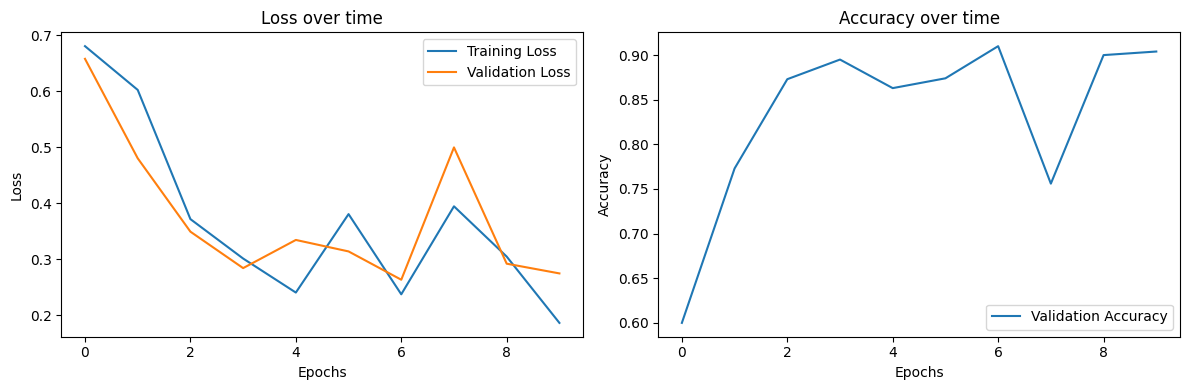

In [20]:
plt.figure(figsize=(12, 4))

# Training and validation loss over epochs
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.legend()

# Validation accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over time')
plt.legend()

plt.tight_layout()
plt.show()

The training and validation losses decrease over time, and the validation accuracy increases over time. This is a good sign. However, at the 7th epoch they suddenly get worse and then start to improve again. This could be due to randomness or outliers in the data, and it's not something to be concerned about since by the 10th epoch all metrics improve again.

### Evaluating the model

The following function is for evaluating a trained model based on test data in `test_loader`. It takes as parameters `test_loader`, `model`, `criterion` and `device`.

- `test_loader` - The data loader with the test data
- `model` - The model being evaluated
- `criterion` - The loss function to use (should be the same as during training)
- `device` - The device on which to test on

The function is very similar to the validation step in the `train_model` function, so no need to add a lot of comments here.

**Note:** I'm using `.round()` to round predictions to the nearest integer, effectively using a threshold of 0.5. This is a common way to make binary predictions when the model's output is a probability. However, in a real world scenario where such technology would be used to detect AI text and possibly investivate students, a higher threshold should be used to avoid false positives. This would increase precision but decrease the recall of the model on test data, and would ensure that fewer people are wrongfully accused.

In [21]:
# Evaluation function

def evaluate_model(test_loader, model, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss, total_correct, total_labels = 0, 0, 0
        all_predictions = []
        all_targets = []
        for batch in test_loader:
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            ids = batch['ids'][sorted_idx]
            targets = batch['targets'][sorted_idx]

            ids = ids.to(device)
            targets = targets.to(device)

            if isinstance(model, LSTMClassifier):
                predictions = model(ids, text_lengths)
            else:
                predictions = model(ids)

            loss = criterion(predictions, targets)

            total_loss += loss.item() * ids.size(0)
            total_correct += (predictions.round() == targets).sum().item() # Rounding creates a threshold of 0.5
            total_labels += ids.size(0)

            all_predictions.extend(predictions.round().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

        avg_loss = total_loss / total_labels
        avg_acc = total_correct / total_labels

        print(f'Test Loss: {avg_loss:.3f}, Test Accuracy: {avg_acc:.3f}')

        # Generating a classification report and confusion matrix
        class_report = classification_report(all_targets, all_predictions)
        conf_matrix = confusion_matrix(all_targets, all_predictions)

        print(class_report)

    return avg_loss, avg_acc, conf_matrix

In [22]:
test_loss, test_acc, conf_matrix = evaluate_model(test_loader, model, criterion, device)

Test Loss: 0.228, Test Accuracy: 0.923
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       740
         1.0       0.94      0.90      0.92       760

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500



Taking a look at the confusion matrix:

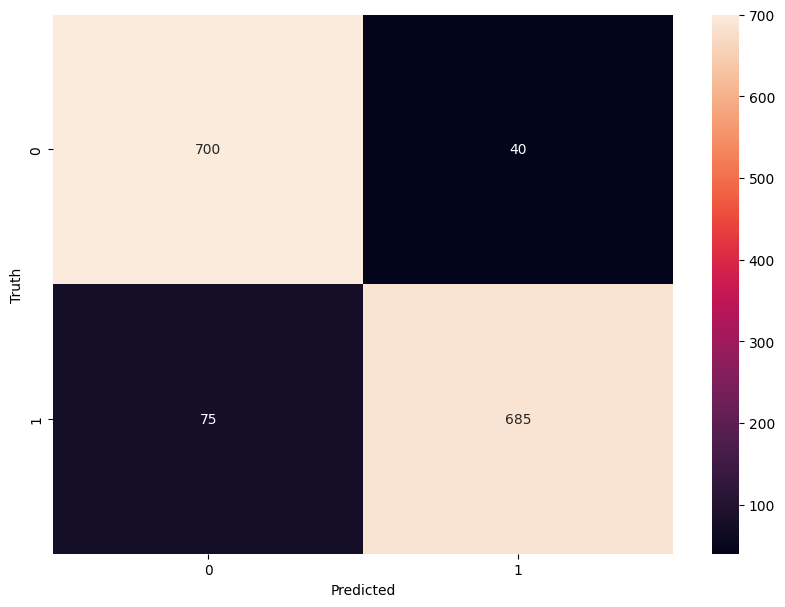

In [23]:
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

The confusion matrix suggests that the model seems to have a relatively balanced performance on both classes, with a slightly higher number of false negatives (75) than false positives (40). This is quite a good result, especially when you take into account the other metrics. The accuracy of 92.3% on the test set is particularly impressive. The loss of 0.228 not bad, but it could be much better and suggests that the accuracy metric may be a bit misleading.

## Convolutional Neural Network (CNN)

### Building The Model

Like the LSTM model, this implementation of CNN also inherits from `nn.Module`. However, the architecture is different:

1. **Embedding Layer (self.embedding)**: This layer which transforms each word in the input into a dense vector of fixed size (`embedding_dim`). The `padding_idx` argument is used to specify the index that represents padding in the input, which will be mapped to a vector of zeros in the embedding space.

2. **Convolutional Layers (self.conv1d_list)**: Several 1D convolutional layers are then applied to the embeddings. Each convolutional layer uses a different filter size, as specified in `filter_sizes`, and a different number of filters, as specified in `num_filters`. The convolution operation slides each filter across the input embeddings and computes the dot product between the filter and the part of the input it is currently on, resulting in a feature map that represents the presence of certain features in the input. The use of multiple filters of different sizes allows the model to learn to recognize different features in the input.

3. **ReLU Activation**: After each convolution, a ReLU (Rectified Linear Unit) activation function is applied. This introduces non-linearity into the model, allowing it to learn more complex patterns.

4. **Max Pooling**: After the convolution and activation, a max pooling operation is applied to each feature map. This reduces the dimensionality of the feature maps while preserving the most important information (the maximum values).

5. **Fully Connected Layer (self.fc)**: The output of the max pooling operations is then concatenated and passed through a fully connected (linear) layer, which computes the dot product of its input and its weights, and adds a bias term. The output size of this layer is equal to the number of classes (`num_classes`), so its output can be interpreted as raw scores for each class.

6. **Dropout (self.dropout)**: A dropout operation is applied before the fully connected layer. This randomly sets a fraction (`p=0.5` in this case) of the input elements to zero at each update during training time, which helps prevent overfitting.

7. **Sigmoid Activation**: Finally, a sigmoid activation function is applied to the output of the fully connected layer. This squashes the raw scores into the range (0, 1), allowing them to be interpreted as probabilities.

The `forward` method defines the forward pass of the model, describing how the input data is transformed into the output predictions.

In [24]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, pad_idx, embedding_dim, filter_sizes, num_filters, num_classes):
        super(CNNClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_dim,
                                      padding_idx=pad_idx)

        # 1D Convolutional Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])

        # Fully connected layer
        self.fc = nn.Linear(np.sum(num_filters), num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, input_ids):
        # Turning words into embeddings
        ids_embedded = self.embedding(input_ids).float()

        # Permuting embedded ids to match input shape requirement
        ids_reshaped = ids_embedded.permute(0, 2, 1)

        # Applying CNN and ReLU. Output shape
        ids_conv_list = [F.relu(conv1d(ids_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling
        ids_pool_list = [F.max_pool1d(id_conv, kernel_size=id_conv.shape[2])
            for id_conv in ids_conv_list]

        # Concatenating and feeding it to fully connected layer
        ids_fc = torch.cat([id_pool.squeeze(dim=2) for id_pool in ids_pool_list],
                         dim=1)

        # Computing logits
        logits = self.fc(self.dropout(ids_fc))

        # Removing unnecessary dimension
        output = torch.squeeze(logits, 1)

        # Applying sigmoid activation function to get output in range 0-1
        output = torch.sigmoid(output)

        return output

### Training The Model

The same `train_model` and `evaluate_model` functions function are used for the CNN model, as they are able to make predictions based on what model is passed in as a parameter.

Creating the model, with the following parameters:

1. `pad_idx = tokenizer.pad_token_id`: This sets the padding index to the ID that the tokenizer (BERT, in our case) uses for the padding token. It is used in the embedding layer to ignore the padding tokens during the forward pass.

2. `vocab_size = len(tokenizer.vocab)`: This sets the vocabulary size to the number of unique tokens in the tokenizer's vocabulary. It is used in the embedding layer to know how many embeddings it needs to learn.

3. `num_classes = 1`: This sets the number of output classes to 1, since the model is being used for binary classification. In this case, the model will output a single probability indicating the likelihood of the positive class.

4. `embedding_dim = 300`: This sets the size of the word embeddings. A size of 300 is a good choice, as it is a good balance between capturing enough information and not making the model too complex.

5. `filter_sizes = [3, 4, 5]`: This sets the sizes of the filters in the convolutional layers. Each size will correspond to a different n-gram size. In this case, the model will learn to recognize features that span 3, 4, or 5 words.

6. `num_filters = [100, 200, 300]`: This sets the number of filters in each convolutional layer. The model will learn this many features for each filter size. Increasing numbers are often used with CNNs when processing text, when the model is expected to learn more complex features.

In [25]:
pad_idx = tokenizer.pad_token_id
vocab_size = len(tokenizer.vocab)
num_classes = 1
embedding_dim = 300
filter_sizes = [3, 4, 5]
num_filters = [100, 200, 300]

model = CNNClassifier(vocab_size, pad_idx, embedding_dim, filter_sizes, num_filters, num_classes)
model = model.to(device)

Let's take a look at the model summary using the same function that was defined earlier:

In [26]:
print_model_summary(model)

Model Summary:
--------------------
embedding.weight	[30522, 300]	9156600
conv1d_list.0.weight	[100, 300, 3]	90000
conv1d_list.0.bias	[100]	100
conv1d_list.1.weight	[200, 300, 4]	240000
conv1d_list.1.bias	[200]	200
conv1d_list.2.weight	[300, 300, 5]	450000
conv1d_list.2.bias	[300]	300
fc.weight	[1, 600]	600
fc.bias	[1]	1
--------------------
Total Params:9937801


We can see from the lines `conv1d_list.0.weight [100, 300, 3]`, `conv1d_list.1.weight [200, 300, 4]` and `conv1d_list.2.weight [300, 300, 5]` how the parameters set above affect the model. Each layer has a different number of filters (100, 200, and 300) and different filter sizes (3, 4, and 5). The second dimension of the weight tensor (300) matches the embedding dimension, meaning that the filters operate on the entire word embeddings.

The total number of parameters in the model is 9,937,801 (including both the weights and the biases of all layers), which is quite a lot more than the 3,069,385 for the LSTM model.

Here, the same `train_loader` and `val_loader` as before are used, since data loaders in PyTorch simply provide a way to iterate over a dataset in batches and don't contain any model-specific information. Adam is equally well-suited for CNN as it is for LSTM:

In [27]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()
epochs = 10

train_losses, val_losses, val_accuracies = train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device)

Epoch 1/10: 100%|██████████| 59/59 [01:18<00:00,  1.34s/batch, training_loss=0.216]


Validation Loss: 0.129, Validation Accuracy: 0.954


Epoch 2/10: 100%|██████████| 59/59 [01:18<00:00,  1.33s/batch, training_loss=0.041]


Validation Loss: 0.078, Validation Accuracy: 0.976


Epoch 3/10: 100%|██████████| 59/59 [01:17<00:00,  1.32s/batch, training_loss=0.103]


Validation Loss: 0.069, Validation Accuracy: 0.979


Epoch 4/10: 100%|██████████| 59/59 [01:17<00:00,  1.32s/batch, training_loss=0.036]


Validation Loss: 0.065, Validation Accuracy: 0.979


Epoch 5/10: 100%|██████████| 59/59 [01:17<00:00,  1.32s/batch, training_loss=0.086]


Validation Loss: 0.066, Validation Accuracy: 0.981


Epoch 6/10: 100%|██████████| 59/59 [01:17<00:00,  1.32s/batch, training_loss=0.045]


Validation Loss: 0.063, Validation Accuracy: 0.979


Epoch 7/10: 100%|██████████| 59/59 [01:17<00:00,  1.31s/batch, training_loss=0.028]


Validation Loss: 0.063, Validation Accuracy: 0.982


Epoch 8/10: 100%|██████████| 59/59 [01:17<00:00,  1.32s/batch, training_loss=0.026]


Validation Loss: 0.060, Validation Accuracy: 0.983


Epoch 9/10: 100%|██████████| 59/59 [01:16<00:00,  1.30s/batch, training_loss=0.008]


Validation Loss: 0.066, Validation Accuracy: 0.983


Epoch 10/10: 100%|██████████| 59/59 [01:18<00:00,  1.33s/batch, training_loss=0.046]


Validation Loss: 0.065, Validation Accuracy: 0.983


### Visualizing Training

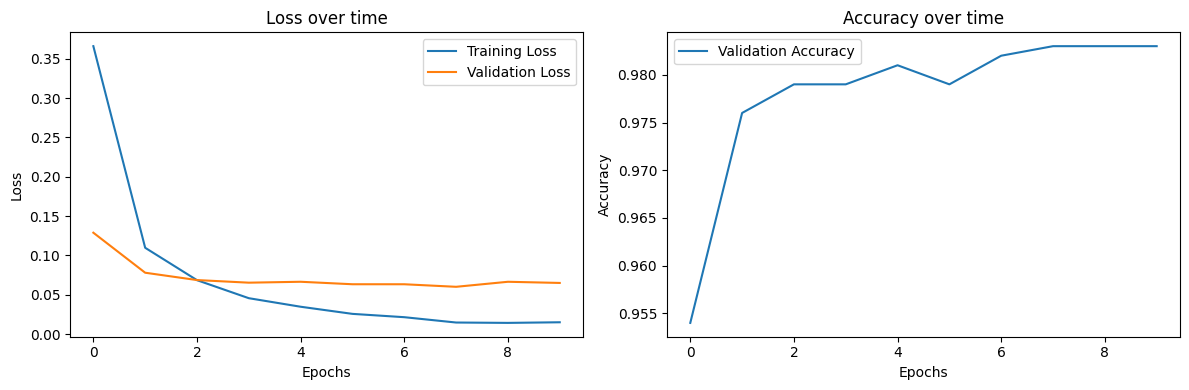

In [28]:
plt.figure(figsize=(12, 4))

# Training and validation loss over epochs
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.legend()

# Validation accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over time')
plt.legend()

plt.tight_layout()
plt.show()

The CNN model clearly learns very efficiently, even better than the LTSM model. After the first epoch, both training and validation loss were already around 0.1, and validation accuracy over 0.975.

The validation loss starts to level out pretty early on, but the validation accuracy continues to increase. This is interesting, and suggests that the model was becoming more confident in its predictions, even though it wasn't necessarily getting better at distinguishing between the two classes.

### Evaluating The Model

In [29]:
test_loss, test_acc, conf_matrix = evaluate_model(test_loader, model, criterion, device)

Test Loss: 0.041, Test Accuracy: 0.984
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       740
         1.0       0.99      0.98      0.98       760

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



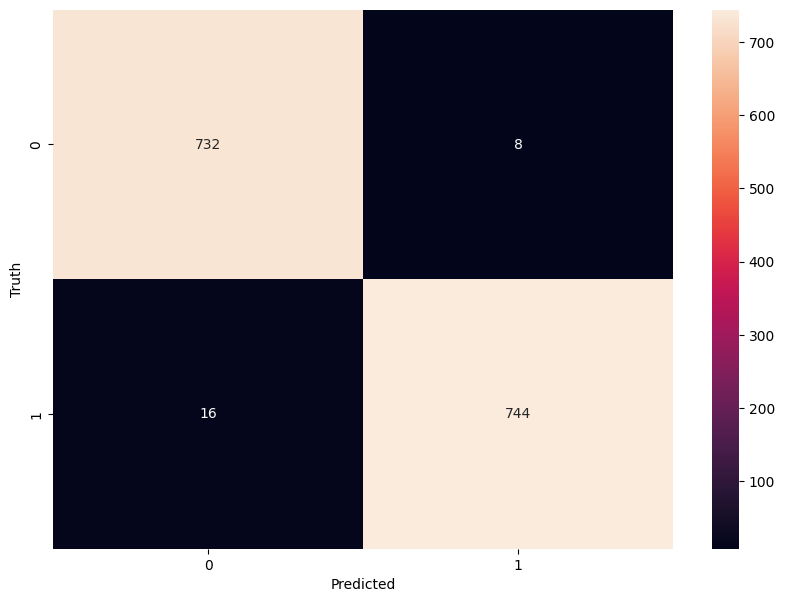

In [30]:
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

This confusion matrix shows that the CNN has fewer false positives and false negatives, with only 8 false positives! That's an excellent result, even better than the LSTM model. The accuracy of 98.4% and loss of 0.041 on the test set is incredibly good.

## Comparison

#### Answering required questions from assignment:

1. **Analyze learning results of the Models**: Both models performed well on the test data, with the LSTM achieving an accuracy of 92.3% and the CNN achieving an accuracy of 98.4%. The CNN model outperformed the LSTM model in terms of both accuracy and loss. The precision, recall, and f1-score are also higher for the CNN model across both classes, indicating that it is better at both identifying positive instances and not falsely classifying negative instances as positive.

2. **How deep learning with different methods went for the selected data and the selected deep learning methods**: Both LSTM and CNN are powerful deep learning methods for text classification. LSTM, being a recurrent neural network, is good at capturing sequential information in the text, while CNN, being a convolutional network, is good at identifying local and global patterns in the text. In this case, the CNN model performed better, which might suggest that the task depends more on identifying key patterns in the text rather than on understanding the sequence of the text.

3. **How well did the method work?**: Both methods worked well, but the CNN model worked exceptionally well with an accuracy of 98.4%. This suggests that the CNN model was able to learn and identify the key features in the text that are important for classification. The CNN model also has fewer false positives and false negatives than the LSTM model.

4. **What do you notice that needs to be developed in the deep learning model (document possible areas of development)? How could you optimize a deep learning model?**: The LSTM model could potentially be improved by tuning hyperparameters such as the learning rate, batch size, number of layers, and the dimension of the hidden state. Regularization techniques such as additional dropout and weight decay could also be explored. For the CNN model, different kernel sizes and numbers of filters could be experimented with. Additionally, building models with more advanced techniques such as attention mechanisms or transformers could be used to improve performance. Training on the whole dataset and using a tokenizer with a higher upper limit for number of tokens could also help, but that would require significantly more in terms of computational resources.

## Conclusion

I chose to use PyTorch to deepen my understanding of deep learning, and I'm happy to say that it was a great success. Having to write out the `forward` functions, training loops and evaluation loops for each model was quite a headache at times, but taught me a lot about how these models work under the hood.

I was incredibly surprised at how good the results were, and it's very promising for the future of AI detection. Of course, the dataset may not have been the best (for example, the humans writing the essays could've been exceptionally good or exceptionally bad at writing essays, and so it was relatively easy for the models to distinguish between those and the generally "average" AI text). It's unfortunate that the creator of the dataset didn't provide more information on how it was collected, so such a dataset could not be used for academic research or commercial purposes.

I tried the CNN model on paragraphs from some of my own high school essays, and unfortunately almost all of them came back as "AI", even though they were written many years before ChatGPT even existed. However, this is unsurprising, as the models in this project were only trained on 10,000 examples, and that's nowhere near enough to apply to real-world scenarios where people have very different writing styles. It would be interesting to see how a model trained on much more data would perform. I believe that with the right amount and quality of data, a pretty good model could be built.

After finishing the project I took a look at what other people had done on Kaggle, and saw that they used different methods but arrived at approximately the same results as I did. It seems like some had more time and resources than I did, and were able to utilize the whole dataset. It's unfortunate that I didn't have the chance, but perhaps one day I will. Some people also used transformer-based models, which I'd love to look into in future projects/studies.

Overall, I had a great experience with this project. I look forward to working more with PyTorch in the future, especially since I'm motivated to continue studying AI in a master's degree and perhaps even a PhD. PyTorch is the gold standard in research, and I understand why; the flexibility and customizability it provides is perfect for groundbreaking discoveries!

### Acknowledgements

- [PyTorch Documentation](https://pytorch.org/docs/stable/index.html) - The PyTorch Foundation

- [LSTM Text Classification Using Pytorch](https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0) - Raymond Cheng

    - An excellent article about the implementation of LSTMs in PyTorch.

- [A Complete Guide to CNN for Sentence Classification with PyTorch](https://chriskhanhtran.github.io/posts/cnn-sentence-classification/) - Chris Tran

    - An amazing introduction to CNNs and how they're typically implemented in PyTorch.

- [BERT Documentation](https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#bertforsequenceclassification) - HuggingFace

- [AI Vs Human Text](https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text/data) - Shayan Gerami
    - The dataset used for this project.